In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
%matplotlib inline

In [2]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


# Data Cleaning 

In [3]:
data = pd.read_csv("2021-05-17 - Recruit Sample Data Train.csv")
data.head()

SetID   Time of Application State  Monthly Net Income  Paycheck Net Income  \
0    436  2018-03-28T17:27:35Z    CA              2000.0               2000.0   
1    615  2018-03-23T13:19:32Z    TX              3500.0               3500.0   
2   1251  2018-02-28T12:04:56Z    CA              3000.0               3000.0   
3    440  2018-03-28T15:47:59Z    CA              1500.0               1500.0   
4   1692  2018-02-13T04:36:00Z    CA              2392.0                598.0   

  Rent or Own  Months at Residence  Bank Account Months Pay Cycle  \
0           R                   12                    6   Monthly   
1           R                   60                   60   Monthly   
2           R                    0                    6   Monthly   
3           R                   12                    6   Monthly   
4           R                  130                   36    Weekly   

   Loan Amount Loan Funded Date Loan Due Date  First Payment Default  
0       300.00       2018-03-28    2018-04-11                  False  
1       641.91       2018-03-23    2018-04-06                  False  
2       117.65       2018-02-28    2018-03-30                   True  
3       117.65       2018-03-28    2018-04-28                  False  
4       300.00       2018-02-13    2018-02-23                  False

In [4]:
data.describe()

SetID  Monthly Net Income  Paycheck Net Income  \
count  1600.0000         1600.000000          1600.000000   
mean   1004.8700         4362.641250          2718.488750   
std     584.0755         5524.868265          4894.909919   
min       2.0000           70.000000            70.000000   
25%     492.7500         2000.000000          1250.000000   
50%    1012.5000         3200.000000          2100.000000   
75%    1514.2500         5139.000000          3500.000000   
max    2000.0000       184000.000000        184000.000000   

       Months at Residence  Bank Account Months  Loan Amount  
count          1600.000000          1600.000000  1600.000000  
mean             63.285625            24.731250   317.974619  
std              70.777592            23.414134   176.993218  
min               0.000000             3.000000   117.650000  
25%              17.000000             6.000000   235.300000  
50%              39.000000            24.000000   300.000000  
75%              81.000000            36.000000   320.592500  
max             690.000000           410.000000   644.240000

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SetID                  1600 non-null   int64  
 1   Time of Application    1600 non-null   object 
 2   State                  1600 non-null   object 
 3   Monthly Net Income     1600 non-null   float64
 4   Paycheck Net Income    1600 non-null   float64
 5   Rent or Own            1600 non-null   object 
 6   Months at Residence    1600 non-null   int64  
 7   Bank Account Months    1600 non-null   int64  
 8   Pay Cycle              1600 non-null   object 
 9   Loan Amount            1600 non-null   float64
 10  Loan Funded Date       1600 non-null   object 
 11  Loan Due Date          1600 non-null   object 
 12  First Payment Default  1600 non-null   bool   
dtypes: bool(1), float64(3), int64(3), object(6)
memory usage: 151.7+ KB


In [6]:
data.columns

Index(['SetID', 'Time of Application', 'State', 'Monthly Net Income',
       'Paycheck Net Income', 'Rent or Own', 'Months at Residence',
       'Bank Account Months', 'Pay Cycle', 'Loan Amount', 'Loan Funded Date',
       'Loan Due Date', 'First Payment Default'],
      dtype='object')

In [7]:
data[['Date of application','Time Application']] = data['Time of Application'].str.split("T",expand=True)

In [8]:
data.drop(columns=['Time of Application'],axis=1,inplace=True)

In [9]:
data

SetID State  Monthly Net Income  Paycheck Net Income Rent or Own  \
0       436    CA              2000.0               2000.0           R   
1       615    TX              3500.0               3500.0           R   
2      1251    CA              3000.0               3000.0           R   
3       440    CA              1500.0               1500.0           R   
4      1692    CA              2392.0                598.0           R   
...     ...   ...                 ...                  ...         ...   
1595    524    TX              5000.0               2500.0           R   
1596    539    TX              1500.0                750.0           R   
1597   1798    CA              4000.0               4000.0           R   
1598   1745    TX              1500.0               1500.0           O   
1599   1550    TX              2000.0               2000.0           R   

      Months at Residence  Bank Account Months Pay Cycle  Loan Amount  \
0                      12                    6   Monthly       300.00   
1                      60                   60   Monthly       641.91   
2                       0                    6   Monthly       117.65   
3                      12                    6   Monthly       117.65   
4                     130                   36    Weekly       300.00   
...                   ...                  ...       ...          ...   
1595                   12                   12  BiWeekly       385.39   
1596                   36                    6  BiWeekly       385.47   
1597                   36                   36   Monthly       235.30   
1598                   12                    6   Monthly       641.91   
1599                   36                    6   Monthly       641.91   

     Loan Funded Date Loan Due Date  First Payment Default  \
0          2018-03-28    2018-04-11                  False   
1          2018-03-23    2018-04-06                  False   
2          2018-02-28    2018-03-30                   True   
3          2018-03-28    2018-04-28                  False   
4          2018-02-13    2018-02-23                  False   
...               ...           ...                    ...   
1595       2018-03-26    2018-04-12                  False   
1596       2018-03-26    2018-04-13                  False   
1597       2018-02-09    2018-03-06                   True   
1598       2018-02-12    2018-02-26                  False   
1599       2018-02-15    2018-03-01                  False   

     Date of application Time Application  
0             2018-03-28        17:27:35Z  
1             2018-03-23        13:19:32Z  
2             2018-02-28        12:04:56Z  
3             2018-03-28        15:47:59Z  
4             2018-02-13        04:36:00Z  
...                  ...              ...  
1595          2018-03-26        14:59:22Z  
1596          2018-03-26        12:50:48Z  
1597          2018-02-08        19:26:00Z  
1598          2018-02-12        11:22:00Z  
1599          2018-02-15        18:16:52Z  

[1600 rows x 14 columns]

In [10]:
second_column = data.pop('Date of application')
third_column=data.pop('Time Application')
data.insert(1, 'Date of application', second_column)
data.insert(2, 'Time Application', third_column)

In [11]:
data

SetID Date of application Time Application State  Monthly Net Income  \
0       436          2018-03-28        17:27:35Z    CA              2000.0   
1       615          2018-03-23        13:19:32Z    TX              3500.0   
2      1251          2018-02-28        12:04:56Z    CA              3000.0   
3       440          2018-03-28        15:47:59Z    CA              1500.0   
4      1692          2018-02-13        04:36:00Z    CA              2392.0   
...     ...                 ...              ...   ...                 ...   
1595    524          2018-03-26        14:59:22Z    TX              5000.0   
1596    539          2018-03-26        12:50:48Z    TX              1500.0   
1597   1798          2018-02-08        19:26:00Z    CA              4000.0   
1598   1745          2018-02-12        11:22:00Z    TX              1500.0   
1599   1550          2018-02-15        18:16:52Z    TX              2000.0   

      Paycheck Net Income Rent or Own  Months at Residence  \
0                  2000.0           R                   12   
1                  3500.0           R                   60   
2                  3000.0           R                    0   
3                  1500.0           R                   12   
4                   598.0           R                  130   
...                   ...         ...                  ...   
1595               2500.0           R                   12   
1596                750.0           R                   36   
1597               4000.0           R                   36   
1598               1500.0           O                   12   
1599               2000.0           R                   36   

      Bank Account Months Pay Cycle  Loan Amount Loan Funded Date  \
0                       6   Monthly       300.00       2018-03-28   
1                      60   Monthly       641.91       2018-03-23   
2                       6   Monthly       117.65       2018-02-28   
3                       6   Monthly       117.65       2018-03-28   
4                      36    Weekly       300.00       2018-02-13   
...                   ...       ...          ...              ...   
1595                   12  BiWeekly       385.39       2018-03-26   
1596                    6  BiWeekly       385.47       2018-03-26   
1597                   36   Monthly       235.30       2018-02-09   
1598                    6   Monthly       641.91       2018-02-12   
1599                    6   Monthly       641.91       2018-02-15   

     Loan Due Date  First Payment Default  
0       2018-04-11                  False  
1       2018-04-06                  False  
2       2018-03-30                   True  
3       2018-04-28                  False  
4       2018-02-23                  False  
...            ...                    ...  
1595    2018-04-12                  False  
1596    2018-04-13                  False  
1597    2018-03-06                   True  
1598    2018-02-26                  False  
1599    2018-03-01                  False  

[1600 rows x 14 columns]

In [12]:
# data.iloc[2]

In [13]:
# data.sort_values(by='SetID', ascending=True)

In [14]:
# data.iloc[2]

In [15]:
data['Date of application']= pd.to_datetime(data['Date of application'])
data['Loan Funded Date']= pd.to_datetime(data['Loan Funded Date'])
data['Loan Due Date']= pd.to_datetime(data['Loan Due Date'])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SetID                  1600 non-null   int64         
 1   Date of application    1600 non-null   datetime64[ns]
 2   Time Application       1600 non-null   object        
 3   State                  1600 non-null   object        
 4   Monthly Net Income     1600 non-null   float64       
 5   Paycheck Net Income    1600 non-null   float64       
 6   Rent or Own            1600 non-null   object        
 7   Months at Residence    1600 non-null   int64         
 8   Bank Account Months    1600 non-null   int64         
 9   Pay Cycle              1600 non-null   object        
 10  Loan Amount            1600 non-null   float64       
 11  Loan Funded Date       1600 non-null   datetime64[ns]
 12  Loan Due Date          1600 non-null   datetime64[ns]
 13  Fir

# Deriving the difference in loan funded date and loan due date 

In [17]:
data.insert(13, "Maturity Days",'', True)

In [18]:
data

SetID Date of application Time Application State  Monthly Net Income  \
0       436          2018-03-28        17:27:35Z    CA              2000.0   
1       615          2018-03-23        13:19:32Z    TX              3500.0   
2      1251          2018-02-28        12:04:56Z    CA              3000.0   
3       440          2018-03-28        15:47:59Z    CA              1500.0   
4      1692          2018-02-13        04:36:00Z    CA              2392.0   
...     ...                 ...              ...   ...                 ...   
1595    524          2018-03-26        14:59:22Z    TX              5000.0   
1596    539          2018-03-26        12:50:48Z    TX              1500.0   
1597   1798          2018-02-08        19:26:00Z    CA              4000.0   
1598   1745          2018-02-12        11:22:00Z    TX              1500.0   
1599   1550          2018-02-15        18:16:52Z    TX              2000.0   

      Paycheck Net Income Rent or Own  Months at Residence  \
0                  2000.0           R                   12   
1                  3500.0           R                   60   
2                  3000.0           R                    0   
3                  1500.0           R                   12   
4                   598.0           R                  130   
...                   ...         ...                  ...   
1595               2500.0           R                   12   
1596                750.0           R                   36   
1597               4000.0           R                   36   
1598               1500.0           O                   12   
1599               2000.0           R                   36   

      Bank Account Months Pay Cycle  Loan Amount Loan Funded Date  \
0                       6   Monthly       300.00       2018-03-28   
1                      60   Monthly       641.91       2018-03-23   
2                       6   Monthly       117.65       2018-02-28   
3                       6   Monthly       117.65       2018-03-28   
4                      36    Weekly       300.00       2018-02-13   
...                   ...       ...          ...              ...   
1595                   12  BiWeekly       385.39       2018-03-26   
1596                    6  BiWeekly       385.47       2018-03-26   
1597                   36   Monthly       235.30       2018-02-09   
1598                    6   Monthly       641.91       2018-02-12   
1599                    6   Monthly       641.91       2018-02-15   

     Loan Due Date Maturity Days  First Payment Default  
0       2018-04-11                                False  
1       2018-04-06                                False  
2       2018-03-30                                 True  
3       2018-04-28                                False  
4       2018-02-23                                False  
...            ...           ...                    ...  
1595    2018-04-12                                False  
1596    2018-04-13                                False  
1597    2018-03-06                                 True  
1598    2018-02-26                                False  
1599    2018-03-01                                False  

[1600 rows x 15 columns]

In [19]:
len(data.index)
data['Maturity Days'][0]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SetID                  1600 non-null   int64         
 1   Date of application    1600 non-null   datetime64[ns]
 2   Time Application       1600 non-null   object        
 3   State                  1600 non-null   object        
 4   Monthly Net Income     1600 non-null   float64       
 5   Paycheck Net Income    1600 non-null   float64       
 6   Rent or Own            1600 non-null   object        
 7   Months at Residence    1600 non-null   int64         
 8   Bank Account Months    1600 non-null   int64         
 9   Pay Cycle              1600 non-null   object        
 10  Loan Amount            1600 non-null   float64       
 11  Loan Funded Date       1600 non-null   datetime64[ns]
 12  Loan Due Date          1600 non-null   datetime64[ns]
 13  Mat

In [20]:
x = data['Loan Due Date'][0] - data['Loan Funded Date'][0]
x=x/np.timedelta64(1,'D')
x

14.0

In [21]:
for x in range(len(data)):
    diff_dates = data['Loan Due Date'][x] - data['Loan Funded Date'][x]
    diff_dates=diff_dates/np.timedelta64(1,'D')
    data['Maturity Days'][x]=diff_dates

<ipython-input-21-cf5f56f54dd0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Maturity Days'][x]=diff_dates


In [22]:
data

SetID Date of application Time Application State  Monthly Net Income  \
0       436          2018-03-28        17:27:35Z    CA              2000.0   
1       615          2018-03-23        13:19:32Z    TX              3500.0   
2      1251          2018-02-28        12:04:56Z    CA              3000.0   
3       440          2018-03-28        15:47:59Z    CA              1500.0   
4      1692          2018-02-13        04:36:00Z    CA              2392.0   
...     ...                 ...              ...   ...                 ...   
1595    524          2018-03-26        14:59:22Z    TX              5000.0   
1596    539          2018-03-26        12:50:48Z    TX              1500.0   
1597   1798          2018-02-08        19:26:00Z    CA              4000.0   
1598   1745          2018-02-12        11:22:00Z    TX              1500.0   
1599   1550          2018-02-15        18:16:52Z    TX              2000.0   

      Paycheck Net Income Rent or Own  Months at Residence  \
0                  2000.0           R                   12   
1                  3500.0           R                   60   
2                  3000.0           R                    0   
3                  1500.0           R                   12   
4                   598.0           R                  130   
...                   ...         ...                  ...   
1595               2500.0           R                   12   
1596                750.0           R                   36   
1597               4000.0           R                   36   
1598               1500.0           O                   12   
1599               2000.0           R                   36   

      Bank Account Months Pay Cycle  Loan Amount Loan Funded Date  \
0                       6   Monthly       300.00       2018-03-28   
1                      60   Monthly       641.91       2018-03-23   
2                       6   Monthly       117.65       2018-02-28   
3                       6   Monthly       117.65       2018-03-28   
4                      36    Weekly       300.00       2018-02-13   
...                   ...       ...          ...              ...   
1595                   12  BiWeekly       385.39       2018-03-26   
1596                    6  BiWeekly       385.47       2018-03-26   
1597                   36   Monthly       235.30       2018-02-09   
1598                    6   Monthly       641.91       2018-02-12   
1599                    6   Monthly       641.91       2018-02-15   

     Loan Due Date Maturity Days  First Payment Default  
0       2018-04-11          14.0                  False  
1       2018-04-06          14.0                  False  
2       2018-03-30          30.0                   True  
3       2018-04-28          31.0                  False  
4       2018-02-23          10.0                  False  
...            ...           ...                    ...  
1595    2018-04-12          17.0                  False  
1596    2018-04-13          18.0                  False  
1597    2018-03-06          25.0                   True  
1598    2018-02-26          14.0                  False  
1599    2018-03-01          14.0                  False  

[1600 rows x 15 columns]

In [23]:
data.iloc[:1:2].equals(data.iloc[:11:12]) 

True

In [24]:
data.State.unique()

array(['CA', 'TX'], dtype=object)

In [25]:
data['Rent or Own'].unique()

array(['R', 'O'], dtype=object)

In [26]:
data['Pay Cycle'].unique()

array(['Monthly', 'Weekly', 'BiWeekly', 'BiMonthly'], dtype=object)

In [27]:
data.drop(columns=['Loan Funded Date','Loan Due Date'],inplace=True)

In [28]:
len(data.index)

1600

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SetID                  1600 non-null   int64         
 1   Date of application    1600 non-null   datetime64[ns]
 2   Time Application       1600 non-null   object        
 3   State                  1600 non-null   object        
 4   Monthly Net Income     1600 non-null   float64       
 5   Paycheck Net Income    1600 non-null   float64       
 6   Rent or Own            1600 non-null   object        
 7   Months at Residence    1600 non-null   int64         
 8   Bank Account Months    1600 non-null   int64         
 9   Pay Cycle              1600 non-null   object        
 10  Loan Amount            1600 non-null   float64       
 11  Maturity Days          1600 non-null   object        
 12  First Payment Default  1600 non-null   bool          
dtypes: 

In [30]:
data['Paycheck Net Income'].round(5)

0       2000.0
1       3500.0
2       3000.0
3       1500.0
4        598.0
         ...  
1595    2500.0
1596     750.0
1597    4000.0
1598    1500.0
1599    2000.0
Name: Paycheck Net Income, Length: 1600, dtype: float64

In [31]:
data['Monthly Net Income'].round(5)

0       2000.0
1       3500.0
2       3000.0
3       1500.0
4       2392.0
         ...  
1595    5000.0
1596    1500.0
1597    4000.0
1598    1500.0
1599    2000.0
Name: Monthly Net Income, Length: 1600, dtype: float64

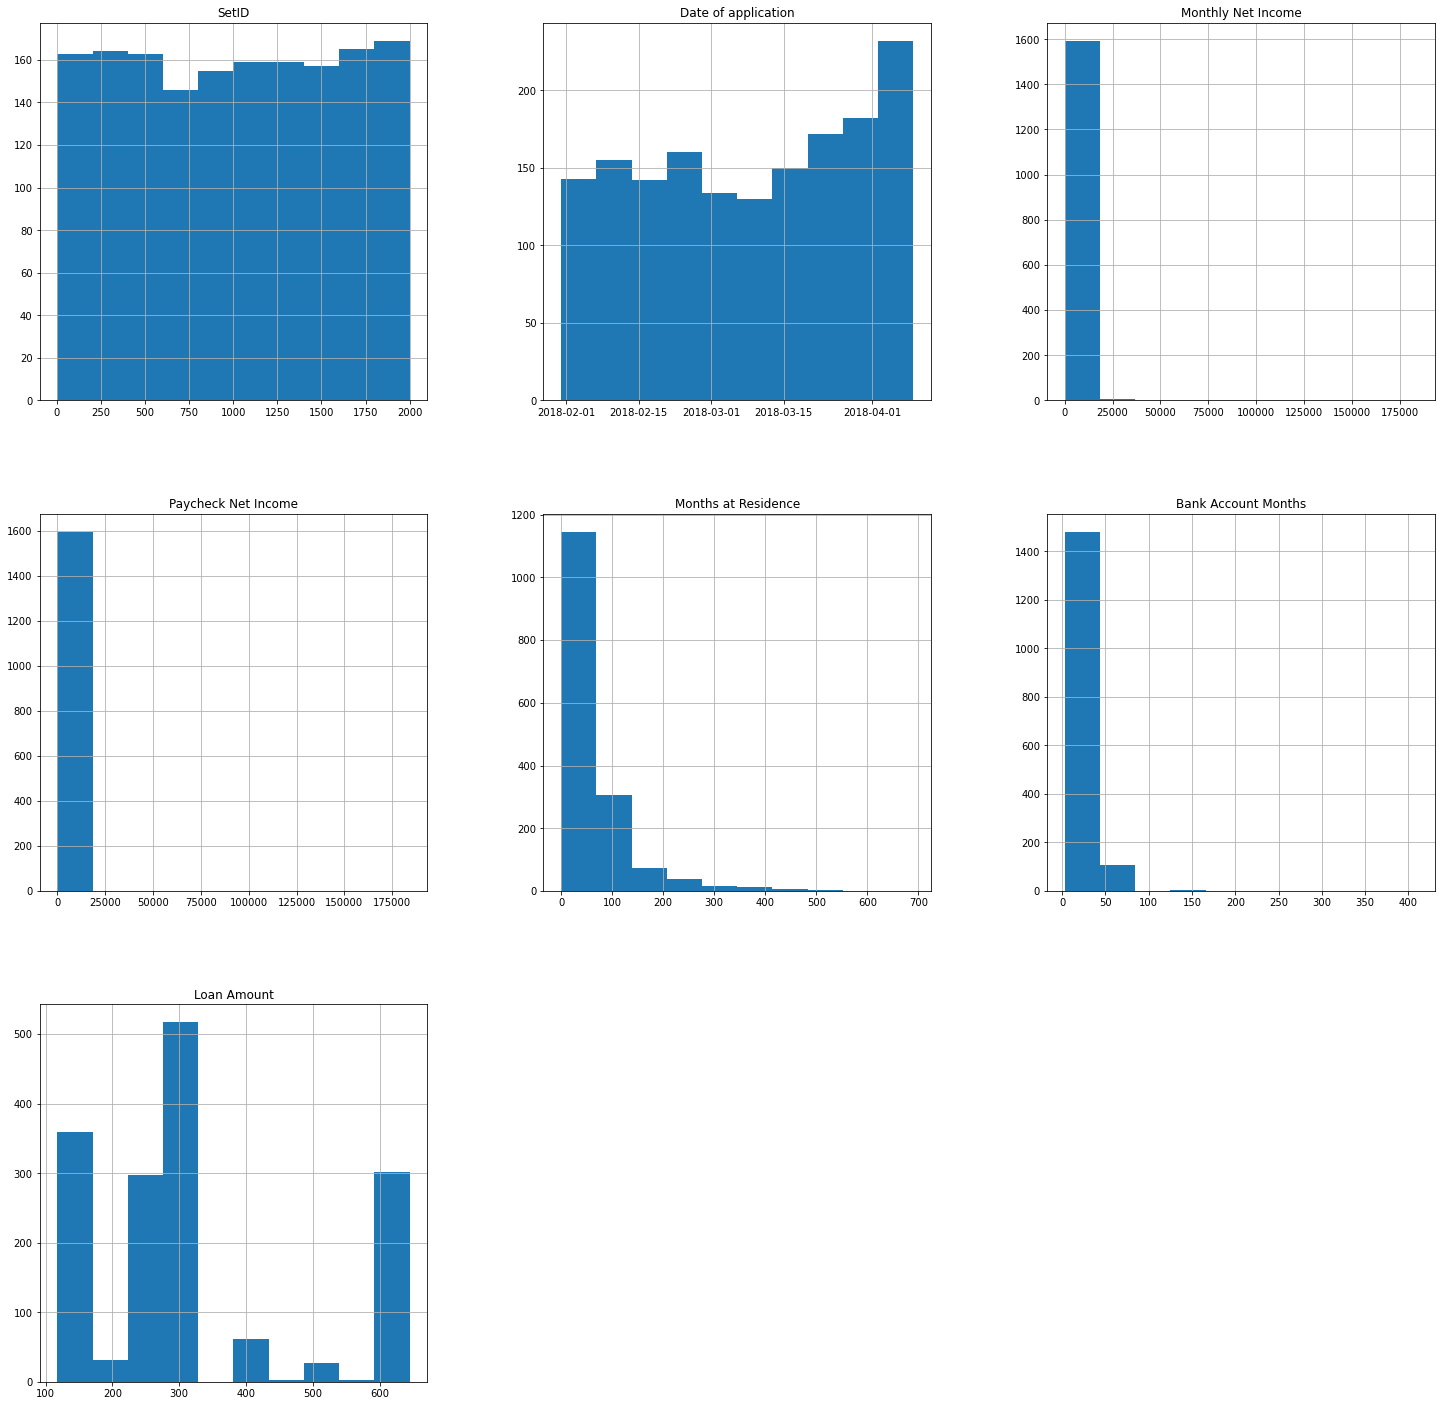

In [32]:
p = data.hist(figsize = (25,25))

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


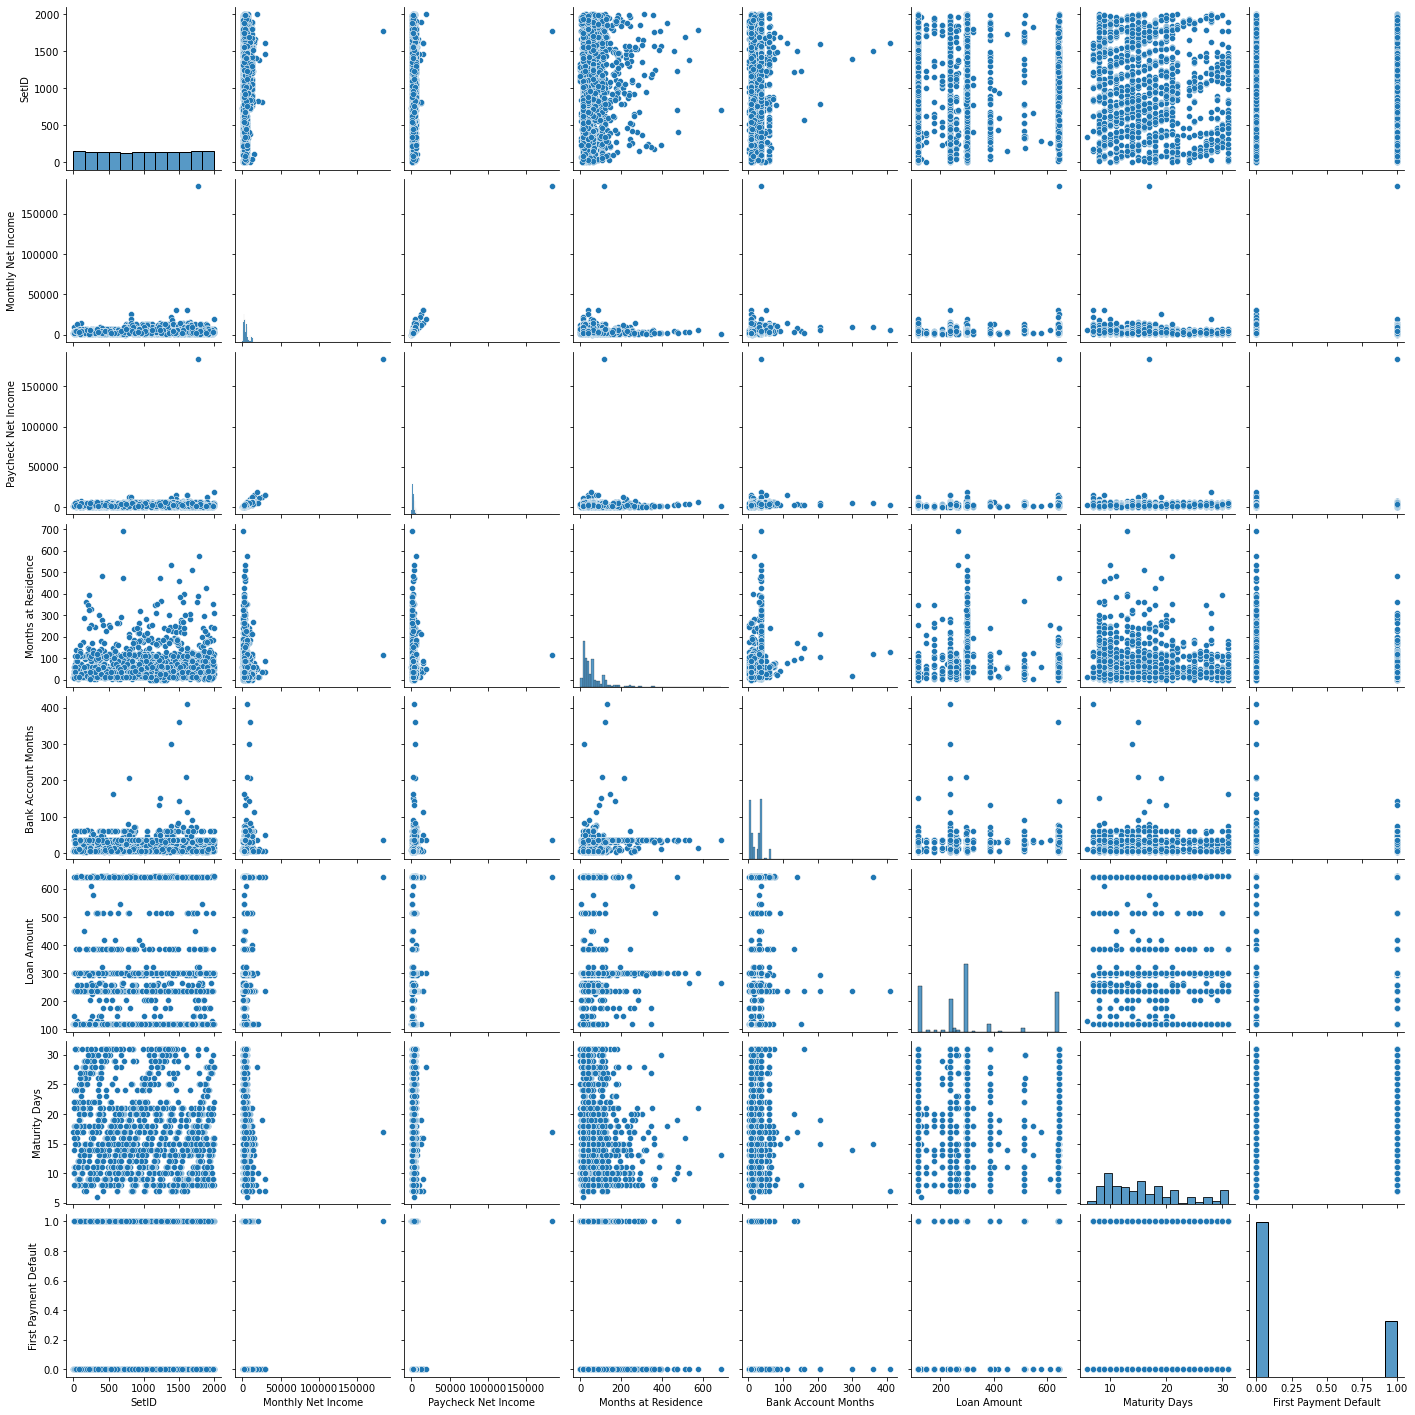

In [33]:
sns.pairplot(data)

In [34]:
data

SetID Date of application Time Application State  Monthly Net Income  \
0       436          2018-03-28        17:27:35Z    CA              2000.0   
1       615          2018-03-23        13:19:32Z    TX              3500.0   
2      1251          2018-02-28        12:04:56Z    CA              3000.0   
3       440          2018-03-28        15:47:59Z    CA              1500.0   
4      1692          2018-02-13        04:36:00Z    CA              2392.0   
...     ...                 ...              ...   ...                 ...   
1595    524          2018-03-26        14:59:22Z    TX              5000.0   
1596    539          2018-03-26        12:50:48Z    TX              1500.0   
1597   1798          2018-02-08        19:26:00Z    CA              4000.0   
1598   1745          2018-02-12        11:22:00Z    TX              1500.0   
1599   1550          2018-02-15        18:16:52Z    TX              2000.0   

      Paycheck Net Income Rent or Own  Months at Residence  \
0                  2000.0           R                   12   
1                  3500.0           R                   60   
2                  3000.0           R                    0   
3                  1500.0           R                   12   
4                   598.0           R                  130   
...                   ...         ...                  ...   
1595               2500.0           R                   12   
1596                750.0           R                   36   
1597               4000.0           R                   36   
1598               1500.0           O                   12   
1599               2000.0           R                   36   

      Bank Account Months Pay Cycle  Loan Amount Maturity Days  \
0                       6   Monthly       300.00          14.0   
1                      60   Monthly       641.91          14.0   
2                       6   Monthly       117.65          30.0   
3                       6   Monthly       117.65          31.0   
4                      36    Weekly       300.00          10.0   
...                   ...       ...          ...           ...   
1595                   12  BiWeekly       385.39          17.0   
1596                    6  BiWeekly       385.47          18.0   
1597                   36   Monthly       235.30          25.0   
1598                    6   Monthly       641.91          14.0   
1599                    6   Monthly       641.91          14.0   

      First Payment Default  
0                     False  
1                     False  
2                      True  
3                     False  
4                     False  
...                     ...  
1595                  False  
1596                  False  
1597                   True  
1598                  False  
1599                  False  

[1600 rows x 13 columns]

In [35]:
data['First Payment Default'].unique()

array([False,  True])

In [36]:
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
 data['First Payment Default'].isnull().values.any()

False

In [38]:
data['First Payment Default'].value_counts()

False    1175
True      425
Name: First Payment Default, dtype: int64

<AxesSubplot:xlabel='State'>

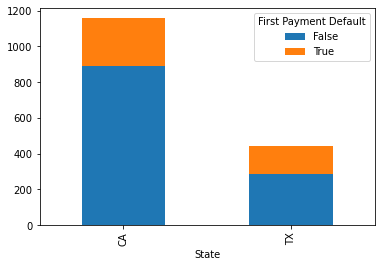

In [39]:
pd.crosstab(data['State'],data['First Payment Default']).plot(kind="bar",stacked=True)

In [40]:
data['State'].value_counts()

CA    1159
TX     441
Name: State, dtype: int64

In [41]:
data['State'].groupby(data['First Payment Default']).value_counts()

First Payment Default  State
False                  CA       888
                       TX       287
True                   CA       271
                       TX       154
Name: State, dtype: int64

<AxesSubplot:xlabel='Rent or Own'>

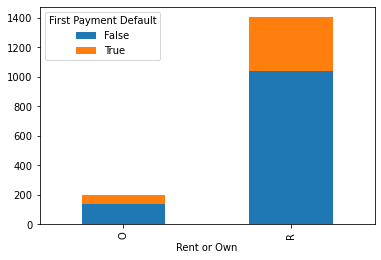

In [42]:
pd.crosstab(data['Rent or Own'],data['First Payment Default']).plot(kind="bar",stacked=True)

In [43]:
data['Rent or Own'].groupby(data['First Payment Default']).value_counts()

First Payment Default  Rent or Own
False                  R              1038
                       O               137
True                   R               368
                       O                57
Name: Rent or Own, dtype: int64

In [44]:
label_encoder = preprocessing.LabelEncoder()
data['State']= label_encoder.fit_transform(data['State']) 
data.head()

SetID Date of application Time Application  State  Monthly Net Income  \
0    436          2018-03-28        17:27:35Z      0              2000.0   
1    615          2018-03-23        13:19:32Z      1              3500.0   
2   1251          2018-02-28        12:04:56Z      0              3000.0   
3    440          2018-03-28        15:47:59Z      0              1500.0   
4   1692          2018-02-13        04:36:00Z      0              2392.0   

   Paycheck Net Income Rent or Own  Months at Residence  Bank Account Months  \
0               2000.0           R                   12                    6   
1               3500.0           R                   60                   60   
2               3000.0           R                    0                    6   
3               1500.0           R                   12                    6   
4                598.0           R                  130                   36   

  Pay Cycle  Loan Amount Maturity Days  First Payment Default  
0   Monthly       300.00          14.0                  False  
1   Monthly       641.91          14.0                  False  
2   Monthly       117.65          30.0                   True  
3   Monthly       117.65          31.0                  False  
4    Weekly       300.00          10.0                  False

In [45]:
label_encoder = preprocessing.LabelEncoder()
data['Rent or Own']= label_encoder.fit_transform(data['Rent or Own']) 
data.head()

SetID Date of application Time Application  State  Monthly Net Income  \
0    436          2018-03-28        17:27:35Z      0              2000.0   
1    615          2018-03-23        13:19:32Z      1              3500.0   
2   1251          2018-02-28        12:04:56Z      0              3000.0   
3    440          2018-03-28        15:47:59Z      0              1500.0   
4   1692          2018-02-13        04:36:00Z      0              2392.0   

   Paycheck Net Income  Rent or Own  Months at Residence  Bank Account Months  \
0               2000.0            1                   12                    6   
1               3500.0            1                   60                   60   
2               3000.0            1                    0                    6   
3               1500.0            1                   12                    6   
4                598.0            1                  130                   36   

  Pay Cycle  Loan Amount Maturity Days  First Payment Default  
0   Monthly       300.00          14.0                  False  
1   Monthly       641.91          14.0                  False  
2   Monthly       117.65          30.0                   True  
3   Monthly       117.65          31.0                  False  
4    Weekly       300.00          10.0                  False

In [46]:
data = pd.get_dummies(data, columns = ['Pay Cycle'])
data

SetID Date of application Time Application  State  Monthly Net Income  \
0       436          2018-03-28        17:27:35Z      0              2000.0   
1       615          2018-03-23        13:19:32Z      1              3500.0   
2      1251          2018-02-28        12:04:56Z      0              3000.0   
3       440          2018-03-28        15:47:59Z      0              1500.0   
4      1692          2018-02-13        04:36:00Z      0              2392.0   
...     ...                 ...              ...    ...                 ...   
1595    524          2018-03-26        14:59:22Z      1              5000.0   
1596    539          2018-03-26        12:50:48Z      1              1500.0   
1597   1798          2018-02-08        19:26:00Z      0              4000.0   
1598   1745          2018-02-12        11:22:00Z      1              1500.0   
1599   1550          2018-02-15        18:16:52Z      1              2000.0   

      Paycheck Net Income  Rent or Own  Months at Residence  \
0                  2000.0            1                   12   
1                  3500.0            1                   60   
2                  3000.0            1                    0   
3                  1500.0            1                   12   
4                   598.0            1                  130   
...                   ...          ...                  ...   
1595               2500.0            1                   12   
1596                750.0            1                   36   
1597               4000.0            1                   36   
1598               1500.0            0                   12   
1599               2000.0            1                   36   

      Bank Account Months  Loan Amount Maturity Days  First Payment Default  \
0                       6       300.00          14.0                  False   
1                      60       641.91          14.0                  False   
2                       6       117.65          30.0                   True   
3                       6       117.65          31.0                  False   
4                      36       300.00          10.0                  False   
...                   ...          ...           ...                    ...   
1595                   12       385.39          17.0                  False   
1596                    6       385.47          18.0                  False   
1597                   36       235.30          25.0                   True   
1598                    6       641.91          14.0                  False   
1599                    6       641.91          14.0                  False   

      Pay Cycle_BiMonthly  Pay Cycle_BiWeekly  Pay Cycle_Monthly  \
0                       0                   0                  1   
1                       0                   0                  1   
2                       0                   0                  1   
3                       0                   0                  1   
4                       0                   0                  0   
...                   ...                 ...                ...   
1595                    0                   1                  0   
1596                    0                   1                  0   
1597                    0                   0                  1   
1598                    0                   0                  1   
1599                    0                   0                  1   

      Pay Cycle_Weekly  
0                    0  
1                    0  
2                    0  
3                    0  
4                    1  
...                ...  
1595                 0  
1596                 0  
1597                 0  
1598                 0  
1599                 0  

[1600 rows x 16 columns]

In [47]:
first_col = data.pop('Pay Cycle_BiMonthly')
second_col=data.pop('Pay Cycle_BiWeekly')
third_col=data.pop('Pay Cycle_Monthly')
fourth_col=data.pop('Pay Cycle_Weekly')
data.insert(8, 'Pay Cycle_BiMonthly', first_col)
data.insert(9, 'Pay Cycle_BiWeekly', second_col)
data.insert(10, 'Pay Cycle_Monthly', third_col)
data.insert(11, 'Pay Cycle_Weekly', fourth_col)

In [48]:
data

SetID Date of application Time Application  State  Monthly Net Income  \
0       436          2018-03-28        17:27:35Z      0              2000.0   
1       615          2018-03-23        13:19:32Z      1              3500.0   
2      1251          2018-02-28        12:04:56Z      0              3000.0   
3       440          2018-03-28        15:47:59Z      0              1500.0   
4      1692          2018-02-13        04:36:00Z      0              2392.0   
...     ...                 ...              ...    ...                 ...   
1595    524          2018-03-26        14:59:22Z      1              5000.0   
1596    539          2018-03-26        12:50:48Z      1              1500.0   
1597   1798          2018-02-08        19:26:00Z      0              4000.0   
1598   1745          2018-02-12        11:22:00Z      1              1500.0   
1599   1550          2018-02-15        18:16:52Z      1              2000.0   

      Paycheck Net Income  Rent or Own  Months at Residence  \
0                  2000.0            1                   12   
1                  3500.0            1                   60   
2                  3000.0            1                    0   
3                  1500.0            1                   12   
4                   598.0            1                  130   
...                   ...          ...                  ...   
1595               2500.0            1                   12   
1596                750.0            1                   36   
1597               4000.0            1                   36   
1598               1500.0            0                   12   
1599               2000.0            1                   36   

      Pay Cycle_BiMonthly  Pay Cycle_BiWeekly  Pay Cycle_Monthly  \
0                       0                   0                  1   
1                       0                   0                  1   
2                       0                   0                  1   
3                       0                   0                  1   
4                       0                   0                  0   
...                   ...                 ...                ...   
1595                    0                   1                  0   
1596                    0                   1                  0   
1597                    0                   0                  1   
1598                    0                   0                  1   
1599                    0                   0                  1   

      Pay Cycle_Weekly  Bank Account Months  Loan Amount Maturity Days  \
0                    0                    6       300.00          14.0   
1                    0                   60       641.91          14.0   
2                    0                    6       117.65          30.0   
3                    0                    6       117.65          31.0   
4                    1                   36       300.00          10.0   
...                ...                  ...          ...           ...   
1595                 0                   12       385.39          17.0   
1596                 0                    6       385.47          18.0   
1597                 0                   36       235.30          25.0   
1598                 0                    6       641.91          14.0   
1599                 0                    6       641.91          14.0   

      First Payment Default  
0                     False  
1                     False  
2                      True  
3                     False  
4                     False  
...                     ...  
1595                  False  
1596                  False  
1597                   True  
1598                  False  
1599                  False  

[1600 rows x 16 columns]

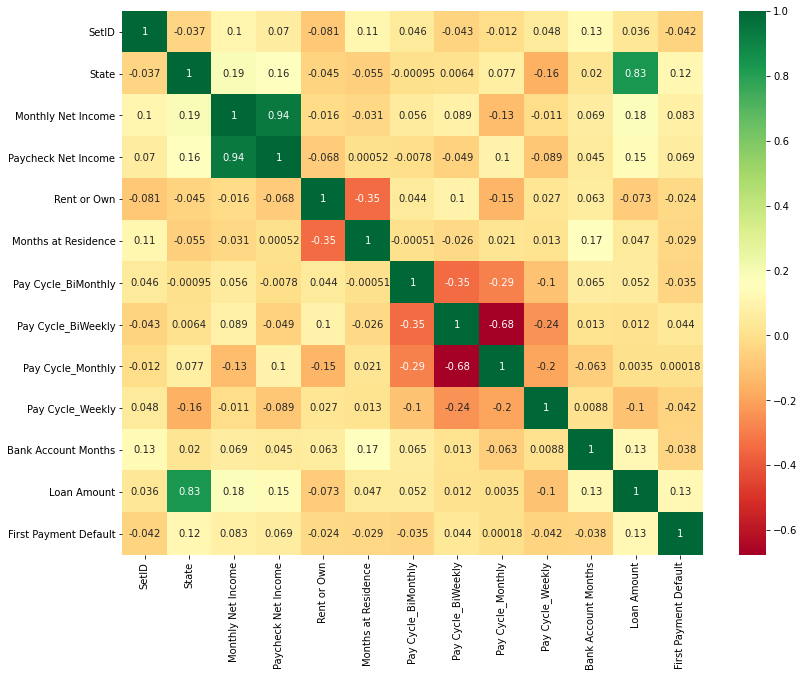

In [49]:
plt.figure(figsize=(13,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(data.corr(), annot=True,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

/Users/abhishekshastry/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/abhishekshastry/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/abhishekshastry/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

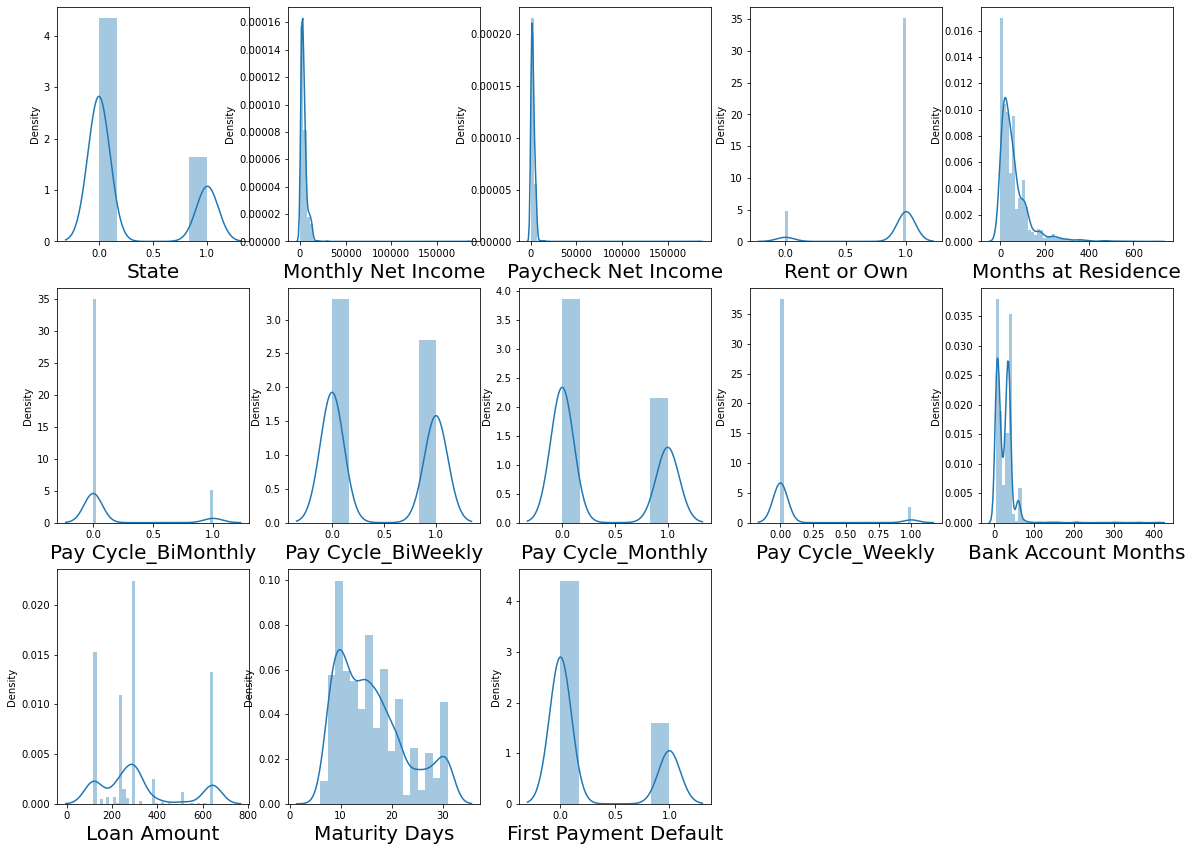

In [50]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data.iloc[:,3:]:
    if plotnumber<=15 :     # as there are 9 columns in the data
        ax = plt.subplot(5,5,plotnumber)
        sns.distplot(data[column],hist=True)
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.show()

<AxesSubplot:>

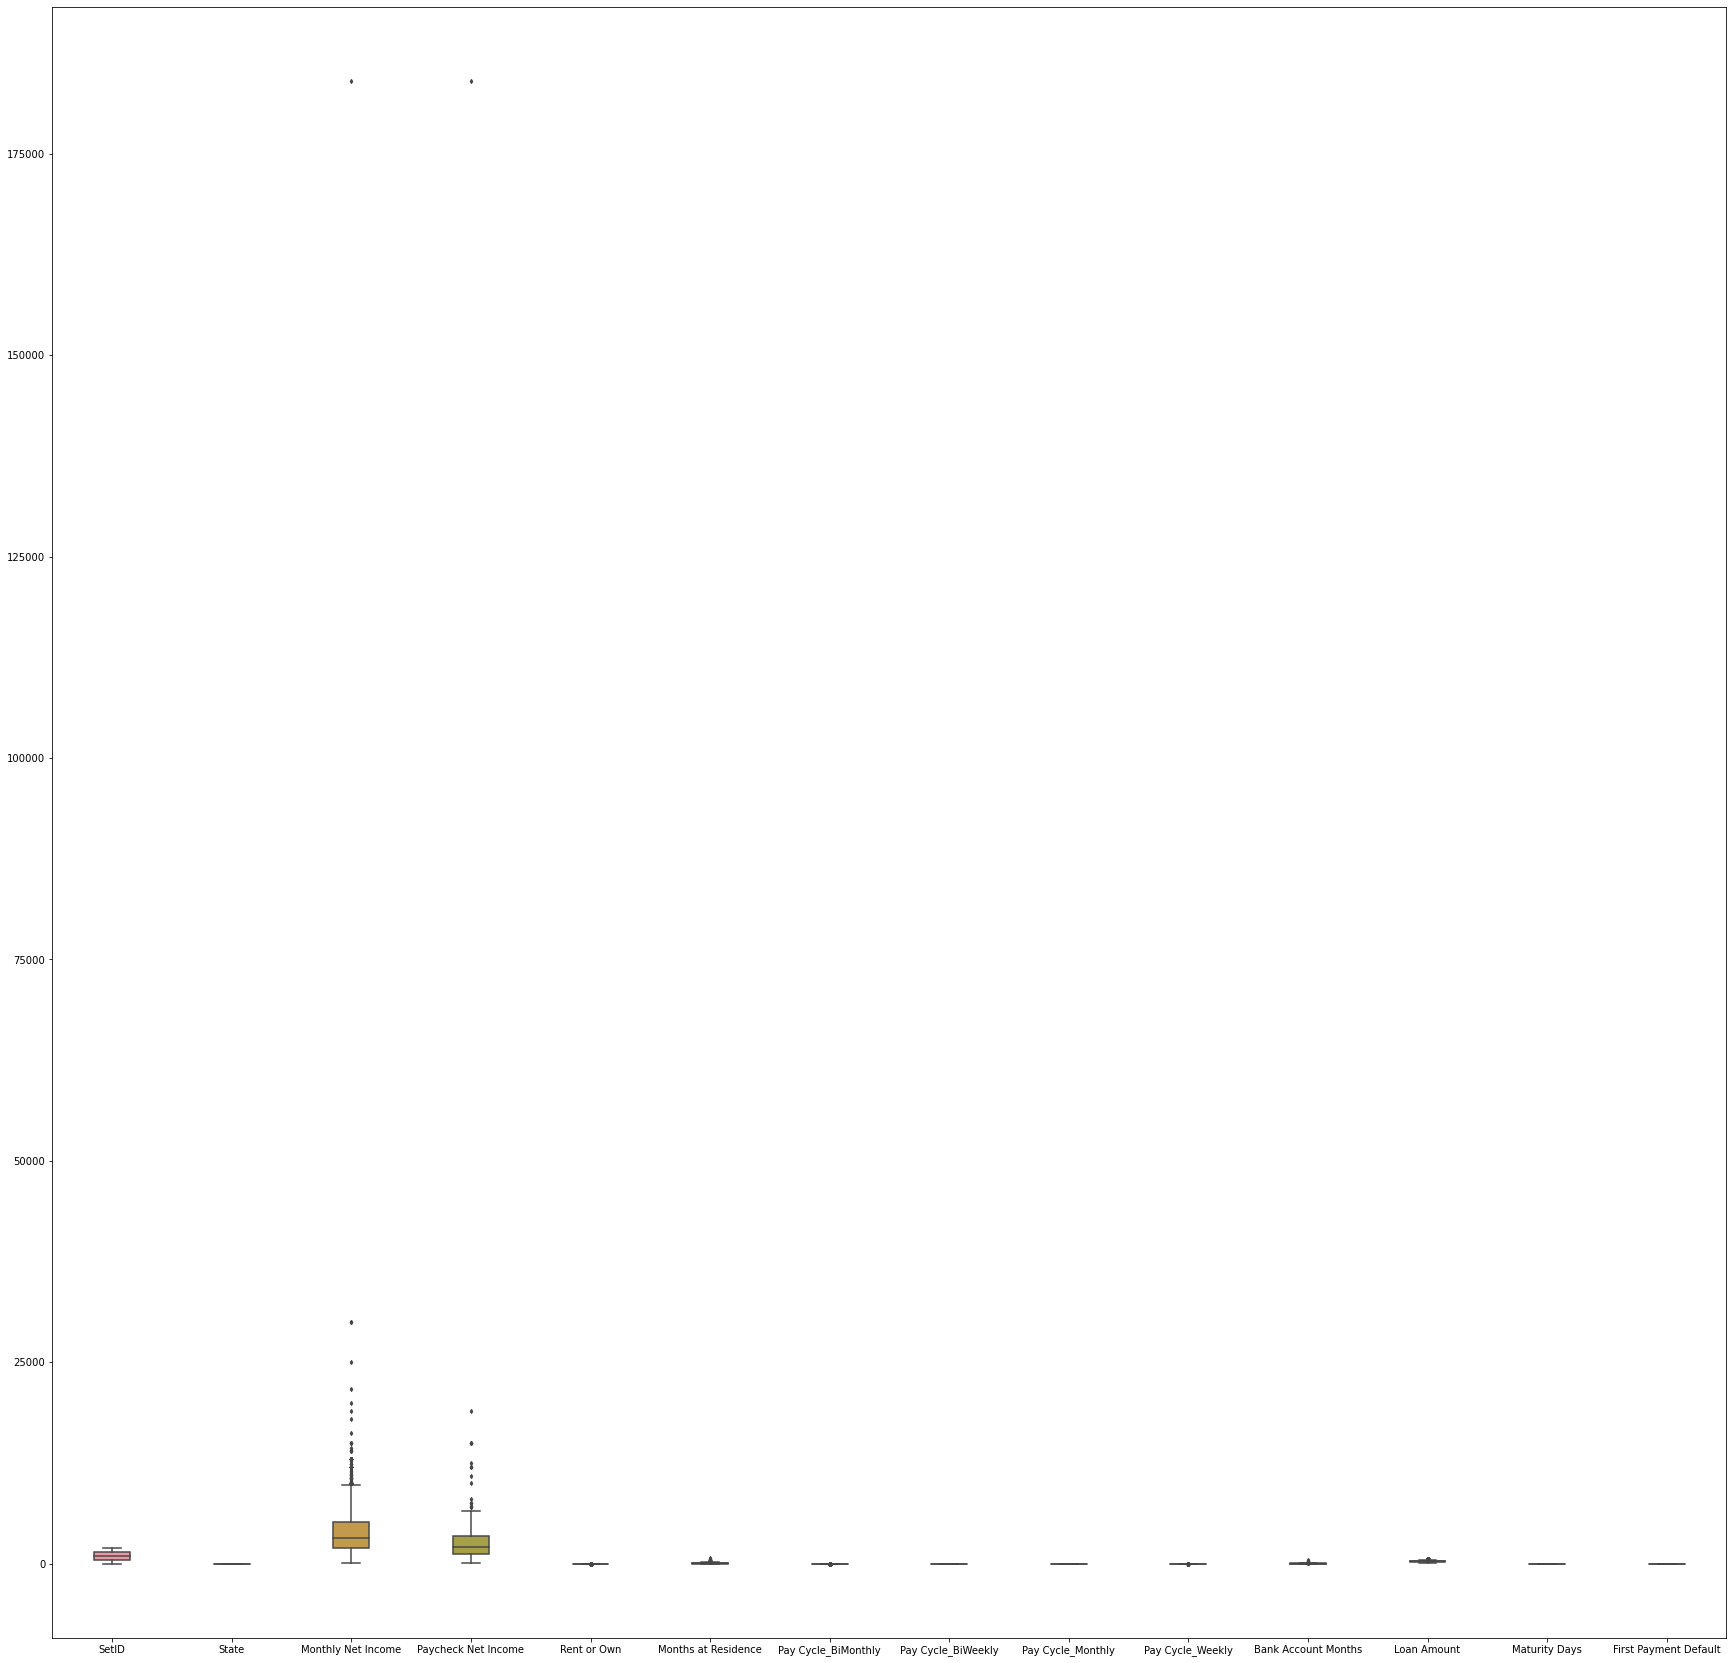

In [51]:
fig, ax = plt.subplots(figsize=(30,30))
sns.boxplot(data=data, width= 0.3,ax=ax,  fliersize=3)

# We see that monthly net income has outliers. Let us find out those

In [52]:
#Treating for Monthly net income

In [53]:
Q1 = np.percentile(data['Monthly Net Income'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(data['Monthly Net Income'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", data.shape)
print(Q1-1.5*IQR)
print(Q3+1.5*IQR)
upper = np.where(data['Monthly Net Income'] >= (Q3+1.5*IQR))
print(upper[0])
lower = np.where(data['Monthly Net Income'] <= (Q1-1.5*IQR))
print(lower[0])

Old Shape:  (1600, 16)
-2722.0
9870.0
[  10   28   46   65   66   69   87   90   94   99  100  106  111  115
  131  143  144  152  155  168  187  205  223  230  232  243  252  253
  265  269  275  280  294  297  327  360  361  364  376  377  383  384
  389  393  396  410  430  442  454  458  463  477  479  481  492  498
  512  520  527  553  557  558  559  560  563  566  586  596  620  623
  631  654  676  684  697  705  712  727  746  750  765  771  780  782
  816  827  835  842  854  856  861  864  882  889  922  932  944  981
  996 1029 1031 1036 1069 1070 1104 1106 1109 1143 1158 1161 1194 1198
 1205 1226 1236 1254 1256 1257 1270 1275 1286 1288 1303 1313 1319 1322
 1331 1342 1347 1349 1355 1366 1385 1421 1433 1442 1455 1461 1494 1512
 1531 1539 1559 1567 1578 1579]
[]


In [54]:
list_outliers=[]
for x in range(0,146):
    u=upper[0][x]
    value=data['Monthly Net Income'].iloc[u]
    list_outliers.append(value)
outliers_Monthly_Net_Income = list(set(list_outliers))
outliers_Monthly_Net_Income

[12800.0,
 10500.0,
 11400.0,
 10000.0,
 15000.0,
 20000.0,
 25000.0,
 30000.0,
 10800.0,
 14000.0,
 10032.0,
 19000.0,
 16188.0,
 11200.0,
 14400.0,
 184000.0,
 11460.0,
 14150.0,
 13000.0,
 13008.0,
 18000.0,
 11608.0,
 10200.0,
 10334.0,
 12000.0,
 21732.0,
 10600.0,
 12400.0,
 12018.0,
 11000.0,
 9980.0]

In [55]:
print(data[data['Monthly Net Income']==12800.0]['First Payment Default'])
print(data[data['Monthly Net Income']==10500.0]['First Payment Default'])
print(data[data['Monthly Net Income']==11400.0]['First Payment Default'])
print(data[data['Monthly Net Income']==10000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==15000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==20000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==25000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==30000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==10800.0]['First Payment Default'])
print(data[data['Monthly Net Income']==14000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==10032.0]['First Payment Default'])
print(data[data['Monthly Net Income']==19000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==16188.0]['First Payment Default'])
print(data[data['Monthly Net Income']==11200.0]['First Payment Default'])
print(data[data['Monthly Net Income']==14400.0]['First Payment Default'])
print(data[data['Monthly Net Income']==184000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==11460.0]['First Payment Default'])
print(data[data['Monthly Net Income']==14150.0]['First Payment Default'])
print(data[data['Monthly Net Income']==13000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==13008.0]['First Payment Default'])
print(data[data['Monthly Net Income']==18000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==11608.0]['First Payment Default'])
print(data[data['Monthly Net Income']==10200.0]['First Payment Default'])
print(data[data['Monthly Net Income']==10334.0]['First Payment Default'])
print(data[data['Monthly Net Income']==12000.0]['First Payment Default'])
print(data[data['Monthly Net Income']==21732.0]['First Payment Default'])
print(data[data['Monthly Net Income']==10600.0]['First Payment Default'])

1303    True
Name: First Payment Default, dtype: bool
327     False
1236    False
Name: First Payment Default, dtype: bool
232    False
Name: First Payment Default, dtype: bool
10       True
28      False
69      False
87       True
90      False
94      False
100     False
115      True
143     False
144     False
152     False
168     False
275     False
360     False
361     False
376     False
377     False
389      True
442      True
557     False
559      True
566     False
586      True
596     False
623     False
676     False
697      True
727      True
746      True
771     False
780     False
782     False
932     False
1029    False
1036     True
1070    False
1104     True
1205    False
1270    False
1275     True
1286     True
1288    False
1331    False
1342     True
1355     True
1366    False
1512     True
1539    False
Name: First Payment Default, dtype: bool
205     True
383    False
864     True
Name: First Payment Default, dtype: bool
1161    True
Name: First Payme

In [56]:
data.drop(upper[0], inplace = True)
data.drop(lower[0], inplace = True)
 
print("New Shape: ", data.shape)

New Shape:  (1454, 16)


In [57]:
len(data.columns)
X = data.iloc[:,3:len(data.columns)-1]
y = data['First Payment Default']

In [58]:
#scalar=StandardScaler().fit_transform(X)
norm = MinMaxScaler().fit_transform(X)
# norm

In [59]:
# type(norm)
df=pd.DataFrame(data=norm, columns= data.iloc[:,3:len(data.columns)-1].columns)
df
# df=pd.DataFrame(data=norm, columns= data.iloc[:,3:len(data.columns)-1].columns)
# df

State  Monthly Net Income  Paycheck Net Income  Rent or Own  \
0       0.0            0.199380             0.278499          1.0   
1       1.0            0.354339             0.494949          1.0   
2       0.0            0.302686             0.422799          1.0   
3       0.0            0.147727             0.206349          1.0   
4       0.0            0.239876             0.076190          1.0   
...     ...                 ...                  ...          ...   
1449    1.0            0.509298             0.350649          1.0   
1450    1.0            0.147727             0.098124          1.0   
1451    0.0            0.405992             0.567100          1.0   
1452    1.0            0.147727             0.206349          0.0   
1453    1.0            0.199380             0.278499          1.0   

      Months at Residence  Pay Cycle_BiMonthly  Pay Cycle_BiWeekly  \
0                0.017391                  0.0                 0.0   
1                0.086957                  0.0                 0.0   
2                0.000000                  0.0                 0.0   
3                0.017391                  0.0                 0.0   
4                0.188406                  0.0                 0.0   
...                   ...                  ...                 ...   
1449             0.017391                  0.0                 1.0   
1450             0.052174                  0.0                 1.0   
1451             0.052174                  0.0                 0.0   
1452             0.017391                  0.0                 0.0   
1453             0.052174                  0.0                 0.0   

      Pay Cycle_Monthly  Pay Cycle_Weekly  Bank Account Months  Loan Amount  \
0                   1.0               0.0             0.007371     0.346285   
1                   1.0               0.0             0.140049     0.995575   
2                   1.0               0.0             0.007371     0.000000   
3                   1.0               0.0             0.007371     0.000000   
4                   0.0               1.0             0.081081     0.346285   
...                 ...               ...                  ...          ...   
1449                0.0               0.0             0.022113     0.508441   
1450                0.0               0.0             0.007371     0.508593   
1451                1.0               0.0             0.081081     0.223419   
1452                1.0               0.0             0.007371     0.995575   
1453                1.0               0.0             0.007371     0.995575   

      Maturity Days  
0              0.32  
1              0.32  
2              0.96  
3              1.00  
4              0.16  
...             ...  
1449           0.44  
1450           0.48  
1451           0.76  
1452           0.32  
1453           0.32  

[1454 rows x 12 columns]

# The target class is highly imbaland as we can see below: Therefore upsampling is performed  to balance it out. 

Text(0, 0.5, 'Frequency')

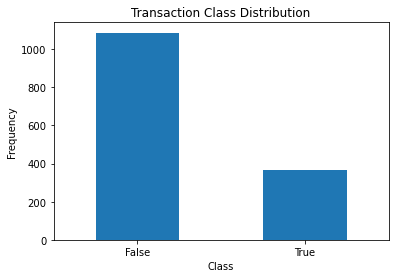

In [60]:
LABELS = ["False", "True"]
count_classes = pd.value_counts(data['First Payment Default'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [61]:
data['First Payment Default'].value_counts()

False    1087
True      367
Name: First Payment Default, dtype: int64

In [62]:
os =  RandomOverSampler(1.0)
df_X_train_res, df_y_train_res = os.fit_resample(df,y)
df_X_train_res.shape,df_y_train_res.shape

/Users/abhishekshastry/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=1.0 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


((2174, 12), (2174,))

In [63]:
df_X_train_res.head()

State  Monthly Net Income  Paycheck Net Income  Rent or Own  \
0    0.0            0.199380             0.278499          1.0   
1    1.0            0.354339             0.494949          1.0   
2    0.0            0.302686             0.422799          1.0   
3    0.0            0.147727             0.206349          1.0   
4    0.0            0.239876             0.076190          1.0   

   Months at Residence  Pay Cycle_BiMonthly  Pay Cycle_BiWeekly  \
0             0.017391                  0.0                 0.0   
1             0.086957                  0.0                 0.0   
2             0.000000                  0.0                 0.0   
3             0.017391                  0.0                 0.0   
4             0.188406                  0.0                 0.0   

   Pay Cycle_Monthly  Pay Cycle_Weekly  Bank Account Months  Loan Amount  \
0                1.0               0.0             0.007371     0.346285   
1                1.0               0.0             0.140049     0.995575   
2                1.0               0.0             0.007371     0.000000   
3                1.0               0.0             0.007371     0.000000   
4                0.0               1.0             0.081081     0.346285   

   Maturity Days  
0           0.32  
1           0.32  
2           0.96  
3           1.00  
4           0.16

In [64]:
df_y_train_res.head()

0    False
1    False
2     True
3    False
4    False
Name: First Payment Default, dtype: bool

# Applying train test split on sampled data

In [65]:
X_train_res,X_test_res,y_train_res,y_test_res = train_test_split(df_X_train_res,df_y_train_res,test_size=0.30, random_state=1)

# Trying to get the best threshold value by comibining multiple models

In [66]:
## Apply RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_res, y_train_res)
ytrain_pred_res = rf_model.predict_proba(X_train_res)
print('RF train roc-auc: {}'.format(roc_auc_score(y_train_res, ytrain_pred_res[:,1])))
ytest_pred_res = rf_model.predict_proba(X_test_res)
print('RF test roc-auc: {}'.format(roc_auc_score(y_test_res, ytest_pred_res[:,1])))

RF train roc-auc: 0.9997760484219629
RF test roc-auc: 0.9292388160613003


In [67]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier=AdaBoostClassifier()
ada_classifier.fit(X_train_res, y_train_res)
ytrain_pred_res = ada_classifier.predict_proba(X_train_res)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train_res, ytrain_pred_res[:,1])))
ytest_pred_res = ada_classifier.predict_proba(X_test_res)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test_res, ytest_pred_res[:,1])))

Adaboost train roc-auc: 0.7298106355382621
Adaboost test roc-auc: 0.6324747398865642


In [68]:
knn_classifier=KNeighborsClassifier()
knn_classifier.fit(X_train_res, y_train_res)
ytrain_pred_res = knn_classifier.predict_proba(X_train_res)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train_res, ytrain_pred_res[:,1])))
ytest_pred_res = knn_classifier.predict_proba(X_test_res)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test_res, ytest_pred_res[:,1])))

Adaboost train roc-auc: 0.8741080847384349
Adaboost test roc-auc: 0.691751493069902


In [69]:
from sklearn.linear_model import LogisticRegression
log_classifier=LogisticRegression()
log_classifier.fit(X_train_res, y_train_res)
ytrain_pred_res = log_classifier.predict_proba(X_train_res)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train_res,ytrain_pred_res[:,1])))
ytest_pred_res = log_classifier.predict_proba(X_test_res)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test_res, ytest_pred_res[:,1])))

Logistic train roc-auc: 0.6184444444444445
Logistic test roc-auc: 0.591020921759381


In [70]:
pred=[]
for model in [rf_model,log_classifier,ada_classifier,knn_classifier]:
    pred.append(pd.Series(model.predict_proba(X_test_res)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test_res,final_prediction)))

Ensemble test roc-auc: 0.8537824437516434


In [71]:
pd.concat(pred,axis=1)

0         1         2    3
0    0.65  0.477427  0.503261  0.4
1    0.15  0.601082  0.501131  0.0
2    0.96  0.603600  0.501402  0.6
3    0.13  0.532449  0.498234  0.0
4    0.29  0.331536  0.490702  0.2
..    ...       ...       ...  ...
648  0.38  0.546542  0.501118  0.0
649  0.21  0.340221  0.495618  0.4
650  0.88  0.574755  0.501118  0.8
651  0.97  0.337222  0.498511  0.6
652  0.87  0.579711  0.501475  0.8

[653 rows x 4 columns]

In [72]:
final_prediction

0      0.507672
1      0.313053
2      0.666251
3      0.290171
4      0.328060
         ...   
648    0.356915
649    0.361460
650    0.688968
651    0.601433
652    0.687797
Length: 653, dtype: float64

In [73]:
#### Calculate the ROc Curve
fpr, tpr, thresholds = roc_curve(y_test_res, final_prediction)
thresholds

array([1.80121508, 0.80121508, 0.79013138, 0.76549648, 0.76325466,
       0.75633462, 0.75618173, 0.75149648, 0.751306  , 0.74661424,
       0.74590497, 0.7411943 , 0.73960846, 0.73899768, 0.7370423 ,
       0.7349686 , 0.72855673, 0.7275473 , 0.72161045, 0.72023968,
       0.72013005, 0.71972184, 0.71436678, 0.71254974, 0.71099143,
       0.71064187, 0.71006687, 0.70016288, 0.70012568, 0.69774521,
       0.6973011 , 0.69664145, 0.69613421, 0.69603172, 0.69396041,
       0.69297049, 0.69128568, 0.68924203, 0.68896818, 0.68831764,
       0.68779656, 0.68757183, 0.68655355, 0.68374794, 0.68301007,
       0.68300619, 0.68086531, 0.68028628, 0.67931754, 0.67881044,
       0.67635195, 0.67600895, 0.67508055, 0.67299176, 0.67297512,
       0.66953423, 0.66914818, 0.6689922 , 0.66788208, 0.66748019,
       0.66652476, 0.66625065, 0.66387214, 0.66276139, 0.66155262,
       0.65842492, 0.65799465, 0.65703421, 0.65504   , 0.65487539,
       0.65463213, 0.65418545, 0.65205989, 0.6506109 , 0.65016

In [74]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test_res, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

thresholds  accuracy
133    0.578263  0.785605
136    0.570185  0.784074
131    0.580602  0.784074
132    0.580193  0.784074
134    0.575379  0.784074

In [75]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

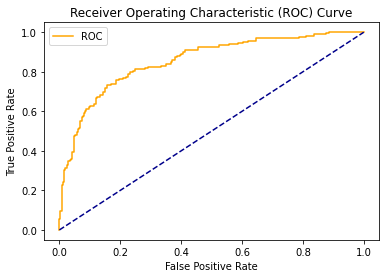

In [76]:
plot_roc_curve(fpr,tpr)

# Using logistic regression for prediction with threshold of 0.51 between 0.55

In [77]:
lr_res=LogisticRegression()
lr_res.fit(X_train_res,y_train_res)

LogisticRegression()

In [78]:
lr_res.predict_proba(X_test_res)

array([[0.52257261, 0.47742739],
       [0.39891782, 0.60108218],
       [0.3963995 , 0.6036005 ],
       ...,
       [0.42524494, 0.57475506],
       [0.66277808, 0.33722192],
       [0.42028867, 0.57971133]])

In [79]:
y_pred_lr_res = (lr_res.predict_proba(X_test_res)[:,1] >=0.517774)
print(y_pred_lr_res)
print(metrics.classification_report(y_pred_lr_res,y_test_res))

[False  True  True  True False False False False False  True False False
  True  True False False False  True False  True  True  True False  True
 False  True  True  True False False False False False  True  True False
  True False False False False False False False  True False False  True
 False False False False  True False  True  True  True False  True False
 False False  True False False  True  True False  True  True  True  True
 False  True False  True  True False False False  True  True False False
 False  True  True  True False False False False False  True  True  True
 False  True False  True  True False  True False False  True False  True
 False False False  True False False False  True  True  True  True False
 False  True False False False  True False False False  True  True  True
  True False False  True  True  True  True False  True  True  True  True
 False  True False False False  True False False  True  True  True  True
 False  True  True False False False False False  T

# Calculating the k value for knn classifier

In [80]:
accuracy_rate = []
for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,X_train_res,y_train_res,cv=10)
    accuracy_rate.append(score.mean())
print(accuracy_rate)

[0.7777390780873753, 0.7376590987272101, 0.6995313037495701, 0.6581441348469214, 0.6509201926384589, 0.6528895768833849, 0.6397402820777434, 0.6482714138286894, 0.6305125558995528, 0.6291924664602683, 0.6278809769521844, 0.6246044031647746, 0.6193584451324389, 0.6127708978328175, 0.6048718610251117, 0.5950077399380805, 0.5937005503955968, 0.5943541451668387, 0.5858015135878912, 0.5838450292397661, 0.5877966976264191, 0.5792311661506708, 0.5766210870313038, 0.5759588923288613, 0.5864809081527348, 0.5845072239422084, 0.5864895080839354, 0.5858230134158926, 0.5838493292053664, 0.5792440660474717, 0.585810113519092, 0.5904024767801856, 0.5890866873065016, 0.595669934640523, 0.6002579979360165, 0.6015780873753009, 0.6074905400756794, 0.6055082559339524, 0.6048503611971104, 0.6107843137254901, 0.6101264189886481, 0.6120915032679739, 0.6088192294461645, 0.6081699346405229, 0.598314413484692, 0.6022617819057448, 0.6002794977640178, 0.6035603715170279, 0.5982972136222909]


Text(0, 0.5, 'Accuracy Rate')

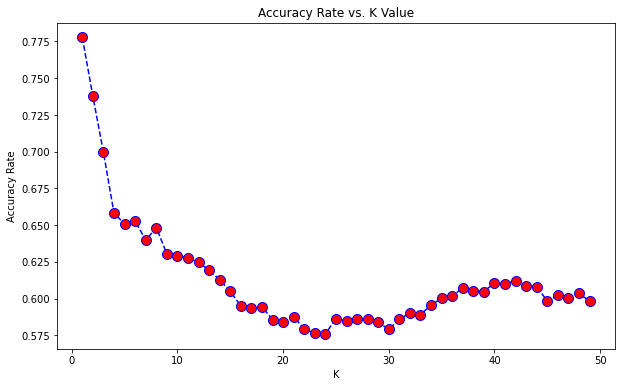

In [81]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50),accuracy_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')

# Using ensemble technqiue to get better results

In [82]:
bag_knn_res = BaggingClassifier(KNeighborsClassifier(n_neighbors=20),
                            n_estimators=10, max_samples=0.5,
                            bootstrap=True, random_state=3,oob_score=True)

In [83]:
bag_knn_res.fit(X_train_res, y_train_res)
print(bag_knn_res.score(X_test_res, y_test_res))
bag_knnPred_res=(bag_knn_res.predict_proba(X_test_res)[:,1] >=0.517774)
print(bag_knnPred_res)
print(metrics.classification_report(y_test_res,bag_knnPred_res))

0.5819295558958653
[ True  True  True  True False False  True False False False False False
 False False False False False False  True  True  True False False  True
 False False  True  True False False False False False  True  True  True
  True False  True False False False False  True  True False False  True
 False False False  True  True  True  True False  True False  True False
  True False  True False False  True False False  True False False  True
 False  True False False  True False False False False  True  True  True
 False False  True  True False  True False False False  True  True False
  True  True False False  True  True  True False False False False  True
 False  True  True False False False False  True  True  True  True False
  True False  True  True False  True  True  True False  True  True  True
 False  True False  True  True  True  True False  True  True  True  True
 False False False False False  True  True False  True False  True  True
 False  True  True False False F

In [84]:
bag_knn_res.predict_proba(X_test_res)

array([[0.3  , 0.7  ],
       [0.275, 0.725],
       [0.4  , 0.6  ],
       ...,
       [0.27 , 0.73 ],
       [0.84 , 0.16 ],
       [0.485, 0.515]])

# Decision Trees 

In [85]:
clf_dt_res=DecisionTreeClassifier()
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,32,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'splitter' : ['best', 'random']
}
grid_search = GridSearchCV(estimator=clf_dt_res,
                     param_grid=grid_param,
                     cv=5,
                    n_jobs =-1)
grid_search.fit(X_train_res,y_train_res)
best_parameters = grid_search.best_params_
print(best_parameters)
grid_search.best_score_


{'criterion': 'gini', 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


0.781723468507334

In [86]:
clf_res = DecisionTreeClassifier(criterion = 'gini', max_depth =22, min_samples_leaf= 1, min_samples_split= 2, splitter ='random')
clf_res.fit(X_train_res,y_train_res)
clf_res.score(X_test_res,y_test_res)
ypred_dt_res=(clf_res.predict_proba(X_test_res)[:,1]>=0.517774)
print(ypred_dt_res)
print(metrics.classification_report(ypred_dt_res,y_test_res))

[False False  True False False False False False  True  True  True False
 False  True False  True  True  True False False  True  True False  True
  True False  True  True  True  True False False  True  True False  True
 False  True  True False  True  True  True  True  True False False  True
  True  True False False  True  True  True False  True False False False
 False False  True  True False  True  True  True  True False  True  True
 False  True  True  True  True  True  True False False  True  True  True
  True False  True  True  True False  True False False  True  True  True
 False False  True  True  True  True  True False  True False  True False
 False  True  True False  True False  True  True  True  True  True False
 False  True  True False  True False  True  True  True False False  True
 False  True False False False  True  True  True False  True False  True
 False False False False False  True False  True  True False False False
  True  True  True  True False  True  True False  T

# Using random forest classifier

In [87]:
rfc_res=RandomForestClassifier()
rfc_res.fit(X_train_res,y_train_res)
y_pred_rfc_res=(rfc_res.predict_proba(X_test_res)[:,1]>=0.581622)
print(y_pred_rfc_res)
print(metrics.classification_report(y_pred_rfc_res,y_test_res))

[ True False  True False False False False False  True False  True False
 False False False  True  True  True  True False False False False False
  True False  True  True  True False False False  True  True False  True
 False  True  True False  True False  True  True  True False False  True
  True  True False False  True  True  True False  True False False False
 False False  True False False  True  True  True  True False  True  True
 False  True  True  True  True False  True False False  True  True  True
 False False  True  True  True False  True False False  True False  True
  True False  True  True  True False  True False  True False  True False
 False False False False False False  True  True  True  True  True False
 False  True  True False False  True False  True  True False False  True
 False False False False False  True  True  True False  True  True  True
 False False False False False  True False  True  True False False False
  True  True  True  True False  True  True False  T

# Working with test csv file

In [88]:
data_test = pd.read_csv("2021-05-17 - Recruit Sample Data Test.csv")
data_test.index

RangeIndex(start=0, stop=400, step=1)

In [89]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SetID                  400 non-null    int64  
 1   Time of Application    400 non-null    object 
 2   State                  400 non-null    object 
 3   Monthly Net Income     400 non-null    float64
 4   Paycheck Net Income    400 non-null    float64
 5   Rent or Own            400 non-null    object 
 6   Months at Residence    400 non-null    int64  
 7   Bank Account Months    400 non-null    int64  
 8   Pay Cycle              400 non-null    object 
 9   Loan Amount            400 non-null    float64
 10  Loan Funded Date       400 non-null    object 
 11  Loan Due Date          400 non-null    object 
 12  First Payment Default  0 non-null      float64
dtypes: float64(4), int64(3), object(6)
memory usage: 40.8+ KB


In [90]:
data_test.describe()

SetID  Monthly Net Income  Paycheck Net Income  \
count   400.00000          400.000000           400.000000   
mean    983.02000         4713.755000          2907.675000   
std     550.74378        10800.036157          5452.204566   
min       1.00000          406.000000           203.000000   
25%     550.50000         2000.000000          1389.000000   
50%     963.50000         3500.000000          2419.500000   
75%    1447.25000         5613.000000          3500.000000   
max    1990.00000       211912.000000        105956.000000   

       Months at Residence  Bank Account Months  Loan Amount  \
count           400.000000           400.000000   400.000000   
mean             61.330000            24.495000   311.007250   
std              70.962704            17.628297   172.920494   
min               0.000000             3.000000   117.650000   
25%              16.500000             6.000000   227.945000   
50%              37.000000            30.000000   300.000000   
75%              75.000000            36.000000   300.000000   
max             600.000000           144.000000   644.240000   

       First Payment Default  
count                    0.0  
mean                     NaN  
std                      NaN  
min                      NaN  
25%                      NaN  
50%                      NaN  
75%                      NaN  
max                      NaN

In [91]:
data_test.insert(12, "Maturity Days",'', True)

In [92]:
data_test['Loan Funded Date']= pd.to_datetime(data_test['Loan Funded Date'])
data_test['Loan Due Date']= pd.to_datetime(data_test['Loan Due Date'])

In [93]:
for x in range(len(data_test.index)):
    diff_dates = data_test['Loan Due Date'][x]-data_test['Loan Funded Date'][x]
    diff_dates=diff_dates/np.timedelta64(1,'D')
    data_test['Maturity Days'][x]=diff_dates

<ipython-input-93-1ea3053b1d3c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Maturity Days'][x]=diff_dates


In [94]:
data_test['Paycheck Net Income'].round(5)
data_test['Monthly Net Income'].round(5)

0      1894.0
1      5000.0
2      2500.0
3      2902.0
4      5000.0
        ...  
395    2548.0
396    1670.0
397    1760.0
398    2500.0
399    8000.0
Name: Monthly Net Income, Length: 400, dtype: float64

In [95]:
label_encoder = preprocessing.LabelEncoder()
data_test['State']= label_encoder.fit_transform(data_test['State']) 
data_test.head()

SetID   Time of Application  State  Monthly Net Income  \
0      1  2018-04-09T23:25:18Z      0              1894.0   
1      4  2018-04-09T20:34:56Z      1              5000.0   
2     14  2018-04-09T17:41:37Z      1              2500.0   
3     19  2018-04-09T16:33:35Z      0              2902.0   
4     28  2018-04-09T14:51:15Z      0              5000.0   

   Paycheck Net Income Rent or Own  Months at Residence  Bank Account Months  \
0                947.0           R                    8                   30   
1               5000.0           O                   36                   36   
2               2500.0           O                  108                    6   
3               1451.0           R                   48                   36   
4               5000.0           R                   12                   12   

  Pay Cycle  Loan Amount Loan Funded Date Loan Due Date Maturity Days  \
0  BiWeekly       300.00       2018-04-10    2018-04-20          10.0   
1   Monthly       642.46       2018-04-10    2018-04-27          17.0   
2   Monthly       644.24       2018-04-09    2018-05-10          31.0   
3  BiWeekly       300.00       2018-04-09    2018-04-20          11.0   
4   Monthly       235.30       2018-04-09    2018-04-30          21.0   

   First Payment Default  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

In [96]:
label_encoder = preprocessing.LabelEncoder()
data_test['Rent or Own']= label_encoder.fit_transform(data_test['Rent or Own']) 
data_test.head()

SetID   Time of Application  State  Monthly Net Income  \
0      1  2018-04-09T23:25:18Z      0              1894.0   
1      4  2018-04-09T20:34:56Z      1              5000.0   
2     14  2018-04-09T17:41:37Z      1              2500.0   
3     19  2018-04-09T16:33:35Z      0              2902.0   
4     28  2018-04-09T14:51:15Z      0              5000.0   

   Paycheck Net Income  Rent or Own  Months at Residence  Bank Account Months  \
0                947.0            1                    8                   30   
1               5000.0            0                   36                   36   
2               2500.0            0                  108                    6   
3               1451.0            1                   48                   36   
4               5000.0            1                   12                   12   

  Pay Cycle  Loan Amount Loan Funded Date Loan Due Date Maturity Days  \
0  BiWeekly       300.00       2018-04-10    2018-04-20          10.0   
1   Monthly       642.46       2018-04-10    2018-04-27          17.0   
2   Monthly       644.24       2018-04-09    2018-05-10          31.0   
3  BiWeekly       300.00       2018-04-09    2018-04-20          11.0   
4   Monthly       235.30       2018-04-09    2018-04-30          21.0   

   First Payment Default  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

In [97]:
data_test = pd.get_dummies(data_test, columns = ['Pay Cycle'])
data_test

SetID   Time of Application  State  Monthly Net Income  \
0        1  2018-04-09T23:25:18Z      0              1894.0   
1        4  2018-04-09T20:34:56Z      1              5000.0   
2       14  2018-04-09T17:41:37Z      1              2500.0   
3       19  2018-04-09T16:33:35Z      0              2902.0   
4       28  2018-04-09T14:51:15Z      0              5000.0   
..     ...                   ...    ...                 ...   
395   1962  2018-02-01T12:09:00Z      0              2548.0   
396   1967  2018-02-01T09:13:00Z      0              1670.0   
397   1971  2018-01-31T22:10:00Z      0              1760.0   
398   1985  2018-01-31T17:48:00Z      0              2500.0   
399   1990  2018-01-31T16:16:00Z      1              8000.0   

     Paycheck Net Income  Rent or Own  Months at Residence  \
0                  947.0            1                    8   
1                 5000.0            0                   36   
2                 2500.0            0                  108   
3                 1451.0            1                   48   
4                 5000.0            1                   12   
..                   ...          ...                  ...   
395               1274.0            1                   17   
396                835.0            0                   72   
397                880.0            1                   14   
398               2500.0            1                   60   
399               4000.0            1                   24   

     Bank Account Months  Loan Amount Loan Funded Date Loan Due Date  \
0                     30       300.00       2018-04-10    2018-04-20   
1                     36       642.46       2018-04-10    2018-04-27   
2                      6       644.24       2018-04-09    2018-05-10   
3                     36       300.00       2018-04-09    2018-04-20   
4                     12       235.30       2018-04-09    2018-04-30   
..                   ...          ...              ...           ...   
395                   30       300.00       2018-02-01    2018-02-16   
396                   30       300.00       2018-02-01    2018-02-09   
397                   36       300.00       2018-02-01    2018-02-21   
398                    6       117.65       2018-01-31    2018-03-02   
399                    6       641.23       2018-02-01    2018-02-09   

    Maturity Days  First Payment Default  Pay Cycle_BiMonthly  \
0            10.0                    NaN                    0   
1            17.0                    NaN                    0   
2            31.0                    NaN                    0   
3            11.0                    NaN                    0   
4            21.0                    NaN                    0   
..            ...                    ...                  ...   
395          15.0                    NaN                    0   
396           8.0                    NaN                    0   
397          20.0                    NaN                    0   
398          30.0                    NaN                    0   
399           8.0                    NaN                    0   

     Pay Cycle_BiWeekly  Pay Cycle_Monthly  Pay Cycle_Weekly  
0                     1                  0                 0  
1                     0                  1                 0  
2                     0                  1                 0  
3                     1                  0                 0  
4                     0                  1                 0  
..                  ...                ...               ...  
395                   1                  0                 0  
396                   1                  0                 0  
397                   1                  0                 0  
398                   0                  1                 0  
399                   1                  0                 0  

[400 rows x 17 columns]

In [98]:
first_col = data_test.pop('Pay Cycle_BiMonthly')
second_col=data_test.pop('Pay Cycle_BiWeekly')
third_col=data_test.pop('Pay Cycle_Monthly')
fourth_col=data_test.pop('Pay Cycle_Weekly')
data_test.insert(7, 'Pay Cycle_BiMonthly', first_col)
data_test.insert(8, 'Pay Cycle_BiWeekly', second_col)
data_test.insert(9, 'Pay Cycle_Monthly', third_col)
data_test.insert(10, 'Pay Cycle_Weekly', fourth_col)

In [99]:
data_test.drop(columns=['Loan Funded Date','Loan Due Date'],inplace=True)

In [100]:
#scalar=StandardScaler()
#scalar_test=scalar.fit_transform(data_test.iloc[:,2:len(data_test.columns)-1])
norm_test = MinMaxScaler().fit_transform(data_test.iloc[:,2:len(data_test.columns)-1])

In [101]:
df_test=pd.DataFrame(data=norm_test,columns= data_test.iloc[:,2:len(data_test.columns)-1].columns)
df_test

State  Monthly Net Income  Paycheck Net Income  Rent or Own  \
0      0.0            0.007035             0.007035          1.0   
1      1.0            0.021720             0.045360          0.0   
2      1.0            0.009900             0.021720          0.0   
3      0.0            0.011801             0.011801          1.0   
4      0.0            0.021720             0.045360          1.0   
..     ...                 ...                  ...          ...   
395    0.0            0.010127             0.010127          1.0   
396    0.0            0.005976             0.005976          0.0   
397    0.0            0.006402             0.006402          1.0   
398    0.0            0.009900             0.021720          1.0   
399    1.0            0.035904             0.035904          1.0   

     Months at Residence  Pay Cycle_BiMonthly  Pay Cycle_BiWeekly  \
0               0.013333                  0.0                 1.0   
1               0.060000                  0.0                 0.0   
2               0.180000                  0.0                 0.0   
3               0.080000                  0.0                 1.0   
4               0.020000                  0.0                 0.0   
..                   ...                  ...                 ...   
395             0.028333                  0.0                 1.0   
396             0.120000                  0.0                 1.0   
397             0.023333                  0.0                 1.0   
398             0.100000                  0.0                 0.0   
399             0.040000                  0.0                 1.0   

     Pay Cycle_Monthly  Pay Cycle_Weekly  Bank Account Months  Loan Amount  \
0                  0.0               0.0             0.191489     0.346285   
1                  1.0               0.0             0.234043     0.996620   
2                  1.0               0.0             0.021277     1.000000   
3                  0.0               0.0             0.234043     0.346285   
4                  1.0               0.0             0.063830     0.223419   
..                 ...               ...                  ...          ...   
395                0.0               0.0             0.191489     0.346285   
396                0.0               0.0             0.191489     0.346285   
397                0.0               0.0             0.234043     0.346285   
398                1.0               0.0             0.021277     0.000000   
399                0.0               0.0             0.021277     0.994284   

     Maturity Days  
0         0.125000  
1         0.416667  
2         1.000000  
3         0.166667  
4         0.583333  
..             ...  
395       0.333333  
396       0.041667  
397       0.541667  
398       0.958333  
399       0.041667  

[400 rows x 12 columns]

# Using Logistic Regression model to predict the test data

In [102]:
lr_test=(lr_res.predict_proba(df_test)[:,1]>=0.517774)
print(lr_test)

[False  True  True False False False False False False False False False
  True False False  True  True False  True False False  True  True False
  True False False False False False False False False  True  True  True
  True False False  True False False False False  True False  True False
 False False False False  True False False False  True  True False False
  True  True False False False False False False False False False  True
 False  True False  True False  True False False False False False False
  True False False  True False  True False False  True False False  True
  True False  True False  True  True False False  True  True False False
 False False False  True  True  True False False False False False  True
 False False False  True  True False False False  True False False False
 False False False False  True False False False False False  True False
 False False False  True False False False False False  True False False
 False False  True False  True False  True False  T

# Using Decision tree to predict the test data

In [103]:
dt_test=(clf_res.predict_proba(df_test)[:,1]>=0.517774)
print(dt_test)

[False  True  True False  True  True  True False  True False  True  True
 False False  True False False False False  True  True False  True  True
  True  True  True False False  True False  True  True  True False  True
 False False False  True  True False  True False False False False  True
 False False  True  True False  True  True  True False False  True  True
 False False  True False False False  True  True  True False  True  True
  True False False False False  True  True  True False  True  True  True
 False  True  True False False False False  True  True  True False False
 False False False  True False False  True False  True  True False  True
  True  True False False  True False False  True False False False  True
 False  True False False False False  True False False False False  True
 False False False False False  True  True False False  True False  True
 False  True False False False False  True  True False  True  True  True
  True False  True  True False False False False  T

# Using KNN to predict the test data

In [104]:
knn_test=(bag_knn_res.predict_proba(df_test)[:,1]>=0.517774)
print(knn_test)

[False  True  True  True False False False  True False False  True  True
  True False  True  True False  True  True  True  True  True  True False
  True False  True False  True  True False  True  True False  True  True
  True False False False False  True False False  True  True False False
  True False  True  True  True  True  True False False  True False False
  True  True  True False False False  True  True False False False  True
  True False  True  True False  True  True False  True  True  True  True
  True  True False  True  True False  True False  True  True  True  True
  True  True  True  True  True  True False False  True  True False False
  True  True False  True  True  True False  True False  True False False
 False  True False  True  True False False  True  True False False False
 False False False  True  True  True  True False False  True  True False
 False False False False  True False  True False  True False False  True
 False False False  True  True  True  True False Fa

# As random forest has the best recall and precision it was made to predict on the test data set.

# using random forest classifier

In [105]:
rfc_test_pred=(rfc_res.predict_proba(df_test)[:,1]>=0.581622)
print(rfc_test_pred)

[False False  True False False False False  True  True False False False
 False False False False False False False False False False  True False
  True False False False False False False False False False False  True
 False False  True  True False False False False  True False False  True
 False False False False False False False False False False False False
 False False  True False  True False False False False False  True False
 False  True  True  True False False  True False  True False  True  True
  True  True False False False  True  True  True  True False False  True
  True  True False False  True False  True False  True  True  True  True
 False False False False  True False False  True False  True False False
 False False False  True False False False False False False False False
 False False False False False False False False False  True False  True
 False False False False False False False False  True  True False False
 False False  True False False False False False  T

In [106]:
data_test["First Payment Default"].replace(np.nan,'',inplace=True)

In [107]:
data_test["First Payment Default"]=rfc_test_pred.tolist()

In [108]:
data_test

SetID   Time of Application  State  Monthly Net Income  \
0        1  2018-04-09T23:25:18Z      0              1894.0   
1        4  2018-04-09T20:34:56Z      1              5000.0   
2       14  2018-04-09T17:41:37Z      1              2500.0   
3       19  2018-04-09T16:33:35Z      0              2902.0   
4       28  2018-04-09T14:51:15Z      0              5000.0   
..     ...                   ...    ...                 ...   
395   1962  2018-02-01T12:09:00Z      0              2548.0   
396   1967  2018-02-01T09:13:00Z      0              1670.0   
397   1971  2018-01-31T22:10:00Z      0              1760.0   
398   1985  2018-01-31T17:48:00Z      0              2500.0   
399   1990  2018-01-31T16:16:00Z      1              8000.0   

     Paycheck Net Income  Rent or Own  Months at Residence  \
0                  947.0            1                    8   
1                 5000.0            0                   36   
2                 2500.0            0                  108   
3                 1451.0            1                   48   
4                 5000.0            1                   12   
..                   ...          ...                  ...   
395               1274.0            1                   17   
396                835.0            0                   72   
397                880.0            1                   14   
398               2500.0            1                   60   
399               4000.0            1                   24   

     Pay Cycle_BiMonthly  Pay Cycle_BiWeekly  Pay Cycle_Monthly  \
0                      0                   1                  0   
1                      0                   0                  1   
2                      0                   0                  1   
3                      0                   1                  0   
4                      0                   0                  1   
..                   ...                 ...                ...   
395                    0                   1                  0   
396                    0                   1                  0   
397                    0                   1                  0   
398                    0                   0                  1   
399                    0                   1                  0   

     Pay Cycle_Weekly  Bank Account Months  Loan Amount Maturity Days  \
0                   0                   30       300.00          10.0   
1                   0                   36       642.46          17.0   
2                   0                    6       644.24          31.0   
3                   0                   36       300.00          11.0   
4                   0                   12       235.30          21.0   
..                ...                  ...          ...           ...   
395                 0                   30       300.00          15.0   
396                 0                   30       300.00           8.0   
397                 0                   36       300.00          20.0   
398                 0                    6       117.65          30.0   
399                 0                    6       641.23           8.0   

     First Payment Default  
0                    False  
1                    False  
2                     True  
3                    False  
4                    False  
..                     ...  
395                  False  
396                  False  
397                   True  
398                   True  
399                   True  

[400 rows x 15 columns]

In [110]:
data_test.to_csv(r'/Users/abhishekshastry/Documents/Interview_takehomes/Netpay/My_Data_TestResult.csv', index=False)